In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Generate dataset and grid
torch.manual_seed(0)  # Set a seed for reproducibility
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x):
    torch.manual_seed(0)  # Reset seed for consistent randomness
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values
torch.manual_seed(0)  # Reset seed for consistent randomness
Y = torch.stack([target_toy(x) for x in X])


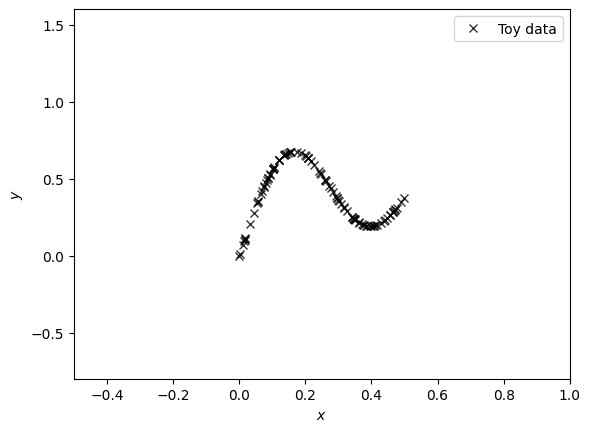

In [2]:
# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

In [3]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, beta):
        super(Model, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2



In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
# Combine X and Y into a TensorDataset
dataset = TensorDataset(X, Y)

# Create a DataLoader for batch processing during training
batch_size = 100  # Adjust according to your needs
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [5]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

epochs = 3000
betas = [0.001, 5, 50, 100]
lr = 0.03
# seed = 2
# torch.manual_seed(seed)
num_ensembles=9

ensemble_1 = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, betas[0],
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True
    )
ensemble_2 = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, betas[1],
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True
    )
ensemble_3 = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, betas[2],
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True
    )
ensemble_4 = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, betas[3],
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True
    )

100%|██████████| 3000/3000 [02:36<00:00, 19.22it/s, loss=tensor(0.0023)]


In [6]:
ensemble_1_outputs = ensemble_1.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
ensemble_2_outputs = ensemble_2.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
ensemble_3_outputs = ensemble_3.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
ensemble_4_outputs = ensemble_4.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

outputs = [ensemble_1_outputs, ensemble_2_outputs, ensemble_3_outputs, ensemble_4_outputs]

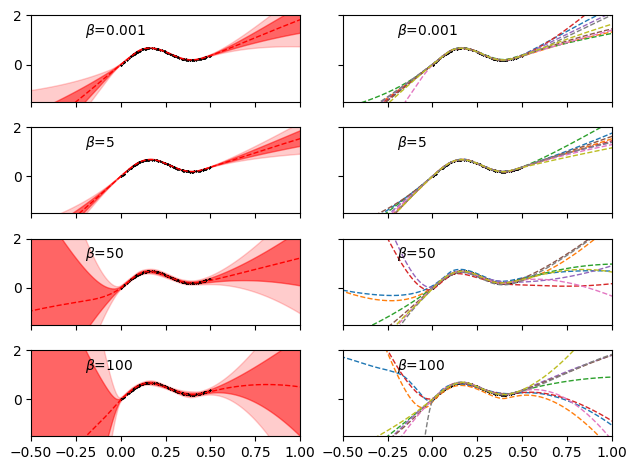

In [7]:

# Plot mean and std for each beta
# fig = plt.figure(figsize=[8, len(betas) * 3], dpi=150)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True)
for i, beta in enumerate(betas):
    # Plot predictive mean and std (left graph)
    # plt.subplot(len(betas), 2, 2 * i + 1)
    axs[i, 0].plot(X, Y, "kx", label="Toy data", markersize=1)
    # plt.title(f'Mean and Deviation for beta={beta}', fontsize=12)
    if beta < 1:
        axs[i, 0].text(-0.2, 1.2, r"$\beta$" + f"={beta:.3f}")
        # axs[i,0].set_title(f"beta={beta:.3f}")
    else:
        axs[i, 0].text(-0.2, 1.2, r"$\beta$=" + f"{int(beta)}")
        # axs[i,0].set_title(f"beta={int(beta)}")
    axs[i, 0].set_xlim(-0.5, 1)
    axs[i, 0].set_ylim(-2, 2)
    # plt.legend()
    axs[i, 0].plot(x_grid, outputs[i]["mean"], "r--", linewidth=1)
    axs[i, 0].fill_between(x_grid.reshape(1, -1)[0], (outputs[i]["mean"] - outputs[i]["std"]).squeeze(), (outputs[i]["mean"] + outputs[i]["std"]).squeeze(), alpha=0.5, color="red")
    axs[i, 0].fill_between(
        x_grid.reshape(1, -1)[0], (outputs[i]["mean"] + 2 * outputs[i]["std"]).squeeze(), (outputs[i]["mean"] - 2 * outputs[i]["std"]).squeeze(), alpha=0.2, color="red"
    )

    # Plot means of each net in ensemble (right graph)
    # plt.subplot(len(betas), 2, 2 * i + 2)
    axs[i, 1].plot(X, Y, "kx", label="Toy data", markersize=1)
    # plt.title(f'Samples for beta={beta}', fontsize=12)
    if beta < 1:
        axs[i, 1].text(-0.2, 1.2, r"$\beta$" + f"={beta:.3f}")
        # axs[i,1].set_title(f"beta={beta:.3f}")
    else:
        axs[i, 1].text(-0.2, 1.2, r"$\beta$=" + f"{int(beta)}")
        # axs[i,1].set_title(f"beta={int(beta)}")

    # if is_latexify_enabled():
    #     axs[i, 1].set_xticklabels([-0.5, 0, 0.5, 1])
    axs[i, 1].set_xlim(-0.5, 1)
    axs[i, 1].set_ylim(-1.5, 2)
    # sns.despine()
    # plt.legend()
    for j in range(num_ensembles):
        axs[i, 1].plot(x_grid, torch.tensor([sublist[j] for sublist in outputs[i]["pred"]]), linestyle="--", linewidth=1)


plt.tight_layout()
# if is_latexify_enabled():
#     plt.subplots_adjust(wspace=5.5)
# pml.savefig("randomized_priors_changing_beta")
# plt.savefig("randomized_priors_changing_beta.png")
plt.show()

In [8]:


# def generate_bootstrap(seed, n_samples):
#     torch.manual_seed(seed)
#     return torch.randint(0, n_samples, (n_samples,), dtype=torch.long)

# def build_bootstrap_datasets(num_ensembles, X, Y, batch_size, shuffle):
#     bootstraps = [generate_bootstrap(42 * i, X.shape[0]) for i in range(1, num_ensembles + 1)]
#     loaders = []
#     for indices in bootstraps:
#         X_b = torch.index_select(X, 0, indices)
#         Y_b = torch.index_select(Y, 0, indices)
#         dataset = TensorDataset(X_b, Y_b)
#         batch_size = 100  # Adjust according to your needs
#         loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#         loaders.append(loader)
#     return loaders

# n_estimators = 4
# bootstrap_datasets = build_bootstrap_datasets(num_ensembles, X, Y, batch_size, shuffle=True)


In [9]:
beta = 50

prior_boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, beta,
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True,
        bootstrap=True
    )
prior_no_boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, beta,
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True,
        bootstrap=False
    )
noprior_boot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, beta,
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True,
        bootstrap=True
    )
noprior_noboot_ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.MSELoss(),
        epochs,
        Model, beta,
        lr = lr,
        num_devices=2,
        num_ensembles=num_ensembles,
        prior=True,
        random_seed=True,
        bootstrap=False
    )

  0%|          | 9/3000 [00:00<02:26, 20.42it/s, loss=tensor(5.9249)] 

100%|██████████| 3000/3000 [02:36<00:00, 19.21it/s, loss=tensor(3.7749e-05)]


In [10]:
prior_boot_output = prior_boot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
prior_no_boot_output = prior_no_boot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
noprior_boot_output = noprior_boot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])
noprior_noboot_output = noprior_noboot_ensemble.posterior_pred(x_grid, f_reg=True, mode=["mean", "std", "pred"])

boot_prior_outputs = [ensemble_1_outputs, ensemble_2_outputs, ensemble_3_outputs, ensemble_4_outputs]

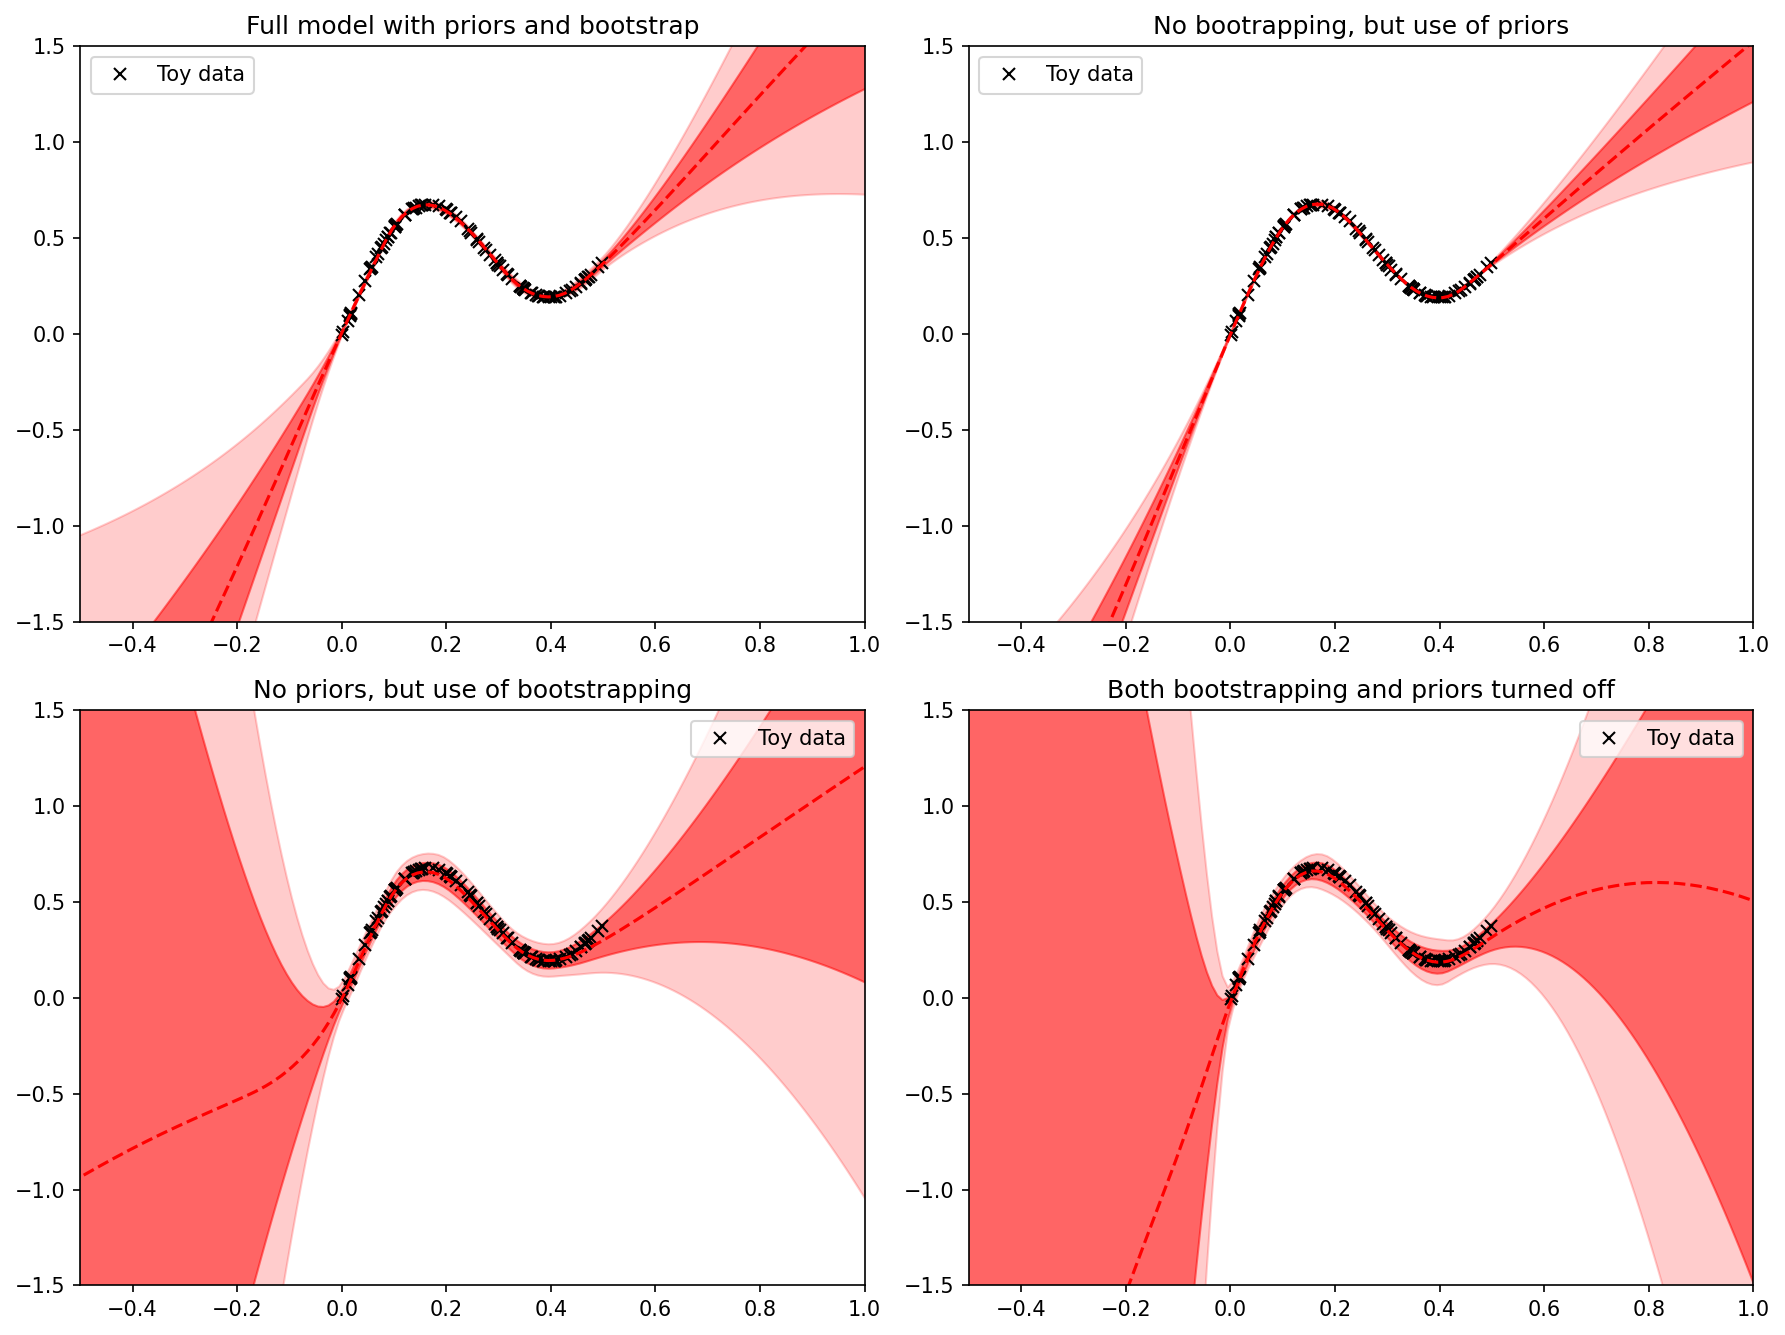

In [13]:
# Plot the four types of models
fig = plt.figure(figsize=[12, 9], dpi=150)
# fig.suptitle('Bootstrapping and priors: impact of model components on result',
#             verticalalignment='center')

# With prior, with bootstrap
plt.subplot(2, 2, 1)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Full model with priors and bootstrap", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, boot_prior_outputs[0]["mean"], "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[0]["mean"] - boot_prior_outputs[0]["std"]).squeeze(), (boot_prior_outputs[0]["mean"] + boot_prior_outputs[0]["std"]).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[0]["mean"] + 2 * boot_prior_outputs[0]["std"]).squeeze(), (boot_prior_outputs[0]["mean"] - 2 * boot_prior_outputs[0]["std"]).squeeze(), alpha=0.2, color="red")

# With prior, without bootstrap
plt.subplot(2, 2, 2)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No bootrapping, but use of priors", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, boot_prior_outputs[1]["mean"], "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[1]["mean"] - boot_prior_outputs[1]["std"]).squeeze(), (boot_prior_outputs[1]["mean"] + boot_prior_outputs[1]["std"]).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[1]["mean"] + 2 * boot_prior_outputs[1]["std"]).squeeze(), (boot_prior_outputs[1]["mean"] - 2 * boot_prior_outputs[1]["std"]).squeeze(), alpha=0.2, color="red")

# Without prior, with bootstrap
plt.subplot(2, 2, 3)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("No priors, but use of bootstrapping", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, boot_prior_outputs[2]["mean"], "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[2]["mean"] - boot_prior_outputs[2]["std"]).squeeze(), (boot_prior_outputs[2]["mean"] + boot_prior_outputs[2]["std"]).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[2]["mean"] + 2 * boot_prior_outputs[2]["std"]).squeeze(), (boot_prior_outputs[2]["mean"] - 2 * boot_prior_outputs[2]["std"]).squeeze(), alpha=0.2, color="red")

# Without prior, without bootstrap
plt.subplot(2, 2, 4)
plt.plot(X, Y, "kx", label="Toy data")
plt.title("Both bootstrapping and priors turned off", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, boot_prior_outputs[3]["mean"], "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[3]["mean"] - boot_prior_outputs[3]["std"]).squeeze(), (boot_prior_outputs[3]["mean"] + boot_prior_outputs[3]["std"]).squeeze(), alpha=0.5, color="red")
plt.fill_between(x_grid.reshape(1, -1)[0], (boot_prior_outputs[3]["mean"] + 2 * boot_prior_outputs[3]["std"]).squeeze(), (boot_prior_outputs[3]["mean"] - 2 * boot_prior_outputs[3]["std"]).squeeze(), alpha=0.2, color="red")

plt.tight_layout()
# plt.savefig("randomized_priors_components.pdf")
# plt.savefig("randomized_priors_components.png")
plt.show()